# Model Selection 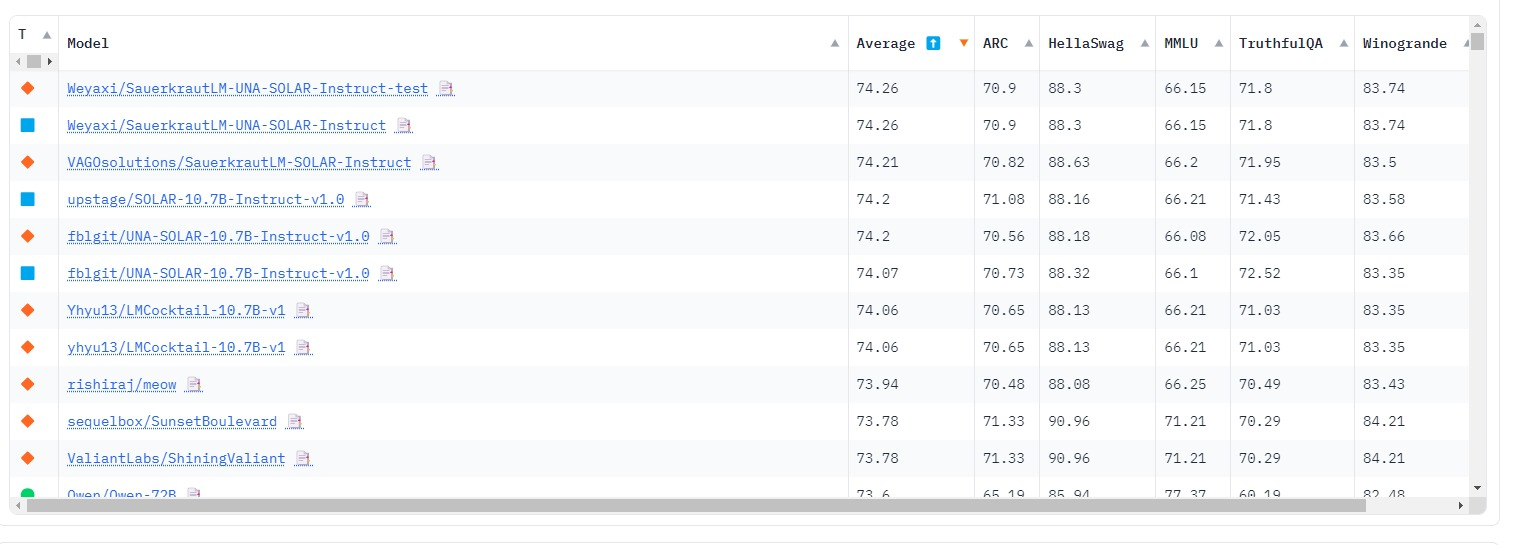

Options to choose from:

considerations- if model size moe, performance enhanced but computational resources higher
1. GPT2 - Text generation

2. T5- text generation


3. Falcon 7B/LLAMA 7B Model --> Trying this for now

open source models benchmarked on the ARC(question-answering with a requirement for complex reasoning.)  and GSM8K( problem-solving skills in a question-answering format) --> choose from the https://huggingface.co/spaces/HuggingFaceH4/open_llm_leaderboard or  LLM Performance leaderboard https://huggingface.co/spaces/optimum/llm-perf-leaderboard, which aims to evaluate the latency and throughput of large language models


4. Hugging Face's CodeBERT: A model trained on a dataset comprising code and natural language and can be used for code generation and other code-related tasks.

5. Hugging Face's CodeParrot: It is a GPT-2 model trained specifically on code datasets, which makes it suitable for generating code snippets.

6. Hugging Face's GPT-Code-Clippy:  trained on a dataset comprising both natural language and code, making them suitable for code synthesis tasks.


model repo- https://huggingface.co/ybelkada/falcon-7b-sharded-bf16

(uses only 75 percent of GPT-3’s training compute)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Install packages

In [ ]:
!pip install trl transformers accelerate git+https://github.com/huggingface/peft.git -Uqqq
!pip install datasets bitsandbytes einops wandb -Uqqq

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


challenges- understanding peft(parameter efficient tuning and its need(instead of training the whole large model , we are training very few additional params --> faster training , v little perf degradation) , can use perf+ lora, prefix tuning, prompt tuning, p-tuning

understanding the libraries

1. trl - transformer reinforcement learning

2. transformers- hugging face large collection of pretrained models

3. accelerate- used to simplify hardware setup for ML models(switch bw CPU, GPU and TPU without the change of training script)

4. datasets

5. wandb- weights and biases ; tool for tracking ie logging model's performanc metrics

6. bits and bytes- provide CUDA oprtns  custom operations that are optimized for speed and memory usage on GPUs for efficient DL model training

7. einops- einstein oprtns ; tensor manipulations

#Import packages

In [ ]:
import torch
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments, GenerationConfig
from peft import LoraConfig, get_peft_model, PeftConfig, PeftModel, prepare_model_for_kbit_training
from trl import SFTTrainer
import warnings
warnings.filterwarnings("ignore")

##hugging face login

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

#Load dataset

In [ ]:
dataset = load_dataset("ttbui/html_alpaca")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['output', 'instruction', 'input', 'response'],
        num_rows: 636
    })
})


#Checking data consistency

If HTML tags are closed properly.

If there are any non-HTML elements within the code that should be removed.

The balance between different types of webpages (e.g., landing pages, contact forms) to ensure diversity.





In [ ]:

from bs4 import BeautifulSoup

# Assuming we're working with the 'train' split
html_data = dataset['train']

# Function to clean and validate HTML
def clean_html(html):
    try:
        soup = BeautifulSoup(html, 'html5lib')  # Using html5lib for lenient parsing
        cleaned_html = soup.prettify()
    except Exception as e:
        print(f"An error occurred while cleaning HTML: {e}")
        cleaned_html = html  # Keep original if error occurs
    return cleaned_html

# Function to remove script and style tags
def remove_noise(html):
    soup = BeautifulSoup(html, 'html5lib')
    for script_or_style in soup(['script', 'style']):
        script_or_style.decompose()
    return soup.prettify()

# Apply the functions to the 'output' column of the dataset
def preprocess_html(example):
    example['output'] = clean_html(example['output'])  #taking the output column of the dataset ie the html code
    example['output'] = remove_noise(example['output'])
    return example

# Apply preprocessing
my_dataset = html_data.map(preprocess_html)
#print(my_dataset[0])
# If you want to see the changes, you can compare the original and preprocessed data
for i in range(5):  # Adjust the range as needed
    print()
    print(f"Original HTML:\n{html_data['output'][i]}")
    print()
    print(f"Cleaned HTML:\n{my_dataset['output'][i]}")



Original HTML:
<html>
  <head>
    <title>My Portfolio</title>
  </head>
  <body>
    <center>
      <h1>My Portfolio</h1>
    </center>
  </body>
</html>

Cleaned HTML:
<html>
 <head>
  <title>
   My Portfolio
  </title>
 </head>
 <body>
  <center>
   <h1>
    My Portfolio
   </h1>
  </center>
 </body>
</html>

Original HTML:
<html>
<head>
    <title>My Web Page</title>
    <link rel="stylesheet" href="https://stackpath.bootstrapcdn.com/bootstrap/4.5.2/css/bootstrap.min.css" integrity="sha384-JcKb8q3iqJ61gNV9KGb8thSsNjpSL0n8PARn9HuZOnIxN0hoP+VmmDGMN5t9UJ0Z" crossorigin="anonymous">
    <script src="https://code.jquery.com/jquery-3.5.1.slim.min.js" integrity="sha384-DfXdz2htPH0lsSSs5nCTpuj/zy4C+OGpamoFVy38MVBnE+IbbVYUew+OrCXaRkfj" crossorigin="anonymous"></script>
    <script src="https://cdn.jsdelivr.net/npm/popper.js@1.16.1/dist/umd/popper.min.js" integrity="sha384-9/reFTGAW83EW2RDu2S0VKaIzap3H66lZH81PoYlFhbGU+6BZp6G7niu735Sk7lN" crossorigin="anonymous"></script>
    <script src="ht

##split the dataset

In [ ]:
from sklearn.model_selection import train_test_split
train_test_val_split = my_dataset["train"].train_test_split(test_size=0.3, seed=42)
test_val_split = train_test_val_split['test'].train_test_split(test_size=0.5, seed=42)

# Assign the splits to variables
train_dataset = train_test_val_split['train']
test_dataset = test_val_split['test']
val_dataset = test_val_split['train']


####concatenating text fields

In [ ]:
def concat_fields(example):
    # Concatenate instruction and input fields if input is not None
    if example['input'] is not None:
        return {'text': example['instruction'] + ' ' + example['input']}
    else:
        return {'text': example['instruction']}

# Apply this function to the dataset
train_dataset = train_dataset.map(concat_fields)
val_dataset = val_dataset.map(concat_fields)
test_dataset = test_dataset.map(concat_fields)

print(train_dataset)
print(test_dataset)
print(val_dataset)

Dataset({
    features: ['output', 'instruction', 'input', 'response', 'text'],
    num_rows: 445
})
Dataset({
    features: ['output', 'instruction', 'input', 'response', 'text'],
    num_rows: 96
})
Dataset({
    features: ['output', 'instruction', 'input', 'response', 'text'],
    num_rows: 95
})


In [ ]:
print(val_dataset)

Dataset({
    features: ['instruction', 'input', 'response', 'output'],
    num_rows: 95
})


#Load the pre-trained sharded falcon-7b model

do not run this--> wont work

In [ ]:
# from transformers import AutoModelForCausalLM
# #for loading any LLM model from hugging face
# model = AutoModelForCausalLM.from_pretrained("ybelkada/falcon-7b-sharded-bf16")
# #download and cache the model which exists in the hugging face directory with its configuraions,weights and files

challenge- why do we use the sharded the model? memory compilcations?

sharding enables the splitting the model's weights across multiple devices or multiple memory units to manage large models that might not fit into the memory of a single device.

the above code crashed since all the available RAM had been used--> solution try for efficient space utilisation



##dealing with running out of ram

possible areas where we can focus to solve the issues:

1. our standard falcon model's weights are stored in 16bit precision
>
solution1 - can use a smaller bit precision like 4 bit precision by using qauntization thru which we can reduce the memory required to store the weights by a factor of 4. This will reduce RAM footprint.

>> >
Problem with quantization- retaining the nrccesary precision while reducing bit representation
solution - We can choose a standard quantization type like nf4

>>
solution 2: can implement double quantization- ie quantization is applied twice; save more memory while retaining precision as compared to the normal quantizaion


2. setting the compute precision to 16 bit: Although we have storage precision as 16 bit, we need to deal with precision used during computation (compute precision).Computations like matrix multiplications and activations during forward and backward passes may be set to default ie float32.
This means that when the model is loaded into memory for inference or training, all computations will utilize bfloat16, which can save memory compared to using full 32-bit precision (float32) while still providing a balance between range and precision.


3. distribution of model's layers across all available GPUs
>
using deviceMap to do so to balance the memory load




In [ ]:
model_name = "ybelkada/falcon-7b-sharded-bf16" # sharded falcon-7b model

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,            # load model in 4-bit precision
    bnb_4bit_quant_type="nf4",    # pre-trained model should be quantized in 4-bit NF format
    bnb_4bit_use_double_quant=True, # Using double quantization as mentioned in QLoRA paper
    bnb_4bit_compute_dtype=torch.bfloat16, # During computation, pre-trained model should be loaded in BF16 format
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config, # Use bitsandbytes config
    device_map="auto",  # Specifying device_map="auto" so that HF Accelerate will determine which GPU to put each layer of the model on
    trust_remote_code=True, # Set trust_remote_code=True to use falcon-7b model with custom code
)

config.json:   0%|          | 0.00/581 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/16.9k [00:00<?, ?B/s]

pytorch_model-00001-of-00008.bin:   0%|          | 0.00/1.92G [00:00<?, ?B/s]

pytorch_model-00002-of-00008.bin:   0%|          | 0.00/1.99G [00:00<?, ?B/s]

pytorch_model-00003-of-00008.bin:   0%|          | 0.00/1.91G [00:00<?, ?B/s]

pytorch_model-00004-of-00008.bin:   0%|          | 0.00/1.91G [00:00<?, ?B/s]

pytorch_model-00005-of-00008.bin:   0%|          | 0.00/1.99G [00:00<?, ?B/s]

pytorch_model-00006-of-00008.bin:   0%|          | 0.00/1.91G [00:00<?, ?B/s]

pytorch_model-00007-of-00008.bin:   0%|          | 0.00/1.91G [00:00<?, ?B/s]

pytorch_model-00008-of-00008.bin:   0%|          | 0.00/921M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

This worked. Other techniques that I can explore:

1. dynamic quantization

2. selective and incemental loading

3. model compression

4. environment optimisation

#Dataset preprocessing

##Tokenization and Padding

steps:

1. converting the both the labels and target into tokens

2. Making each token of same length for batch processing

3. Mapping the text into numerical represenations called token id( different from text encoding techniques like BOW or Word2vec as no semantic meaning carried)

4. These token ids are used to lookup embeddings during forward pass

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True) # Set trust_remote_code=True so that the custom tokenizer code is executed
tokenizer.pad_token = tokenizer.eos_token
# Setting pad_token same as eos_token ie any padded areas are treated as end  of the sequence  during training and inference, which can be beneficial for these models to understand when to stop generating text.
#also helps prevent the model from "seeing" the padding during training and generation, as it's treated as the end of the sequence.

tokenizer_config.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.73M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/281 [00:00<?, ?B/s]

#Fine tuning script

###setting up LORA configuration

Steps for setting up LORA configuration which is a technique for PEFT(parameter efficient fine tuning)

1. kbit training: used to reduce precision of model's training, reducing memory footprint. ie reducing the bit size of weights and activations like 8 or 4 bit instead of standard 32 or 16 bit.
smaller bit can be carried quickly--> more of them fit into memory at once--> faster computations


2. Setup LORA configuration: modifies weights matrix to a low rank format. These trainable low rank matrices are inserted in the pre-trained model that now gets trained on the subset of weights with most imapct and orginal pre-trained wieghts remain frozen , enabling fine-tuning with fewer parameters.


3. Setup training arguments

4. Initialise the trainer

Observations in the code:

1. Regularisation through dropout, scaling factor, and rank of matrices

2. Higher value of alpha and rank can imporv model's performance but at the cost of computational resources.

3. We can hyperparamter tune these through gridSearchCV and monitoring training and validation loss.

In [ ]:
model = prepare_model_for_kbit_training(model)

lora_alpha = 32 # scaling factor for the weight matrices-->  scaling the influence of the learnt params during training
lora_dropout = 0.05 # dropout probability of the LoRA layers
lora_rank = 32 # dimension of the low-rank matrices--> low dim means lower complexity and fewer params

peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_rank,
    bias="none",  # setting to 'none' for only training weight params instead of biases
    task_type="CAUSAL_LM",
    target_modules=[         # Setting names of layers where we want to apply lora to
        "query_key_value",
        "dense",
        "dense_h_to_4h",
        "dense_4h_to_h",
    ]
)

peft_model = get_peft_model(model, peft_config)

###setting up training_arguments

In [ ]:
output_dir = "/content/gdrive/MyDrive/LLM/falcon-7b-sharded-bf16-finetuned-html-code-generation"
per_device_train_batch_size = 2 #batch size of 16 and 32 might give better results
gradient_accumulation_steps = 2  # increase gradient accumulation steps by 2x if batch size is reduced ie here Gradients are accumulated for 2 steps before performing a backward pass and updating the model weights.
optim = "paged_adamw_32bit" # activates the paging for better memory management --> AdamW optimizer variant
save_strategy="steps" # checkpoint save strategy to adopt during training
save_steps = 20 # number of updates steps before two checkpoint saves
logging_steps = 20  # number of update steps between two logs if logging_strategy="steps"
learning_rate = 2e-4  # learning rate for AdamW optimizer
max_grad_norm = 0.3 # maximum gradient norm (for gradient clipping) to avoid exploding gradient problem
max_steps = 320        # training will happen for 320 steps
warmup_ratio = 0.03 # number of steps used for a linear warmup from 0 to learning_rate--> Warmup slowly increases the learning rate from 0 to the specified learning rate to help stabilize training in the early stages.
lr_scheduler_type = "cosine"  # learning rate follows cosine curve--> slowly decrease lr

training_arguments = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    bf16=False,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=True,  #grouping together similar length prompts . this can improve training accuracy
    lr_scheduler_type=lr_scheduler_type,

    push_to_hub= True , #pushing the model's checkpoints to hugging face model hub online

    tf32=False,  #indicates not using TensorFlow 32-bit precision

    evaluation_strategy="steps",
    eval_steps=20,  # Evaluate every 50 steps
    load_best_model_at_end=True,  # Whether to load the best model found during training at the end of training.
)

**Observations in training_arguments code**:

1. MONITOR the  warmup -  A larger warmup might be beneficial if you find the model is not learning initially.


2.  LORA already acts as a form of regularization by limiting the number of parameters updated. However, you could consider increasing lora_dropout slightly if overfitting occurs.


3. Monitor the gradient norms during training, and if they're consistently lower than your threshold, consider increasing the max grad norm.

4. By setting save_steps and logging_steps to 20, the model will save checkpoints and log training information after every 20 steps. This should help in managing the frequency of saves and logs, thus optimizing the use of computational resources.

5. Small batch size, paged optimizer, gradient accumulation are important for training large models like Falcon 7B on hardware with limited memory.

6. The learning rate, scheduler, and warmup settings are crucial hyperparameters and might need tuning based on your specific task and dataset.

**My learning**

DIffernce between epoch and max_steps

When you set max_steps, training will continue for that many optimization
steps, rather than for a specific number of epochs. This means that the Trainer will stop training once it reaches 320 steps regardless of the number of epochs completed.

###Instantiate trainer

#### introducing early stopping

In [ ]:
from transformers import EarlyStoppingCallback

In [ ]:

trainer = SFTTrainer(
    model=peft_model,
    train_dataset=train_dataset,
    peft_config=peft_config,
    dataset_text_field="text",  # The concatenated field
    max_seq_length=1024,
    tokenizer=tokenizer,
    args=training_arguments,
    eval_dataset=val_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

#adjusting norm layers--> for dealing with large models with reduced precision
for name, module in trainer.model.named_modules():
    if "norm" in name:
        module = module.to(torch.float32)

Map:   0%|          | 0/445 [00:00<?, ? examples/s]

Map:   0%|          | 0/95 [00:00<?, ? examples/s]

Map:   0%|          | 0/96 [00:00<?, ? examples/s]

Dataset({
    features: ['instruction', 'input', 'response', 'output', 'text'],
    num_rows: 445
})
Dataset({
    features: ['instruction', 'input', 'response', 'output', 'text'],
    num_rows: 96
})
Dataset({
    features: ['instruction', 'input', 'response', 'output', 'text'],
    num_rows: 95
})


Map:   0%|          | 0/445 [00:00<?, ? examples/s]

Map:   0%|          | 0/95 [00:00<?, ? examples/s]

**My learning**
why kept normalisation layer at full precision ie 32 whereas other parts were kept at 16/8/4?

For each of these normalization layers, it sets the layer to use 32-bit floating-point precision (torch.float32). This is likely done to maintain numerical stability and accuracy.

Even in models where other parts might use reduced precision (like 16-bit floats) for efficiency, it's common to keep normalization layers in full precision to prevent issues like underflow or overflow, which can occur with very small or very large numbers.

#Training

problems to address:

1. Long training time

2. overfitting


3. others(GPU memory limitations)

In [ ]:
peft_model.config.use_cache = False  #disabling caching to save up memory
trainer.train()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
20,2.069900,1.721448
40,1.756300,1.388650
60,1.615200,1.322159
80,1.741900,1.295748
100,1.359600,1.258506
120,1.386100,1.226410
140,1.322000,1.384185
160,1.207200,1.203839
180,1.116100,1.239183
200,1.171500,1.198125


TrainOutput(global_step=260, training_loss=1.3655278535989614, metrics={'train_runtime': 1867.4027, 'train_samples_per_second': 0.685, 'train_steps_per_second': 0.171, 'total_flos': 1403654538872064.0, 'train_loss': 1.3655278535989614, 'epoch': 2.33})

**Learning during training**

During the training 2nd time--> found different training loss at each step

Analysed the possible reasons:

1. train_test_split shuffles data each time. have to introduce seed to prevent this

2. optimisers like adam , sgd etc introduce randomness in the update steps

3. state of GPU can differ from previous sessions

4. certain training parameters (like dropout) are initialized randomly and you haven't set a fixed random seed, you can get different results each time you run the training.

**steps taken for reducing model runtime**:

Credits to the blog: https://betterprogramming.pub/speed-up-llm-inference-83653aa24c47

1. device map for distrbuted training over GPUs

2. mixed precision

3. learning rate scheduling for faster convergence

4. early stopping

5. data preprcoessing- by combining textual fields--> reduced data complexity



**others things that can be explored**:

1. Optimized Data Formats: Use optimized data formats like TFRecord or Parquet to speed up data loading.

2. Optimized Libraries: Ensure you’re using the most up-to-date and optimized versions of libraries. Libraries like cuDNN and MKL can significantly boost performance for certain operations.

3. Gradient Checkpointing: This technique involves trading compute for memory by storing only a subset of intermediate states during the forward pass and recomputing the rest during the backward pass. This can allow for training larger models or using larger batch sizes.

4. Model Pruning: By pruning the model, you remove weights that have little impact on the output, reducing the model size and, consequently, the computation required during both training and inference.

###Saving the model

In [ ]:
trainer.push_to_hub()

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

events.out.tfevents.1703765914.8cab99862580.964.0:   0%|          | 0.00/11.0k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.86k [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

'https://huggingface.co/PrincySinghal991/falcon-7b-sharded-bf16-finetuned-html-code-generation/tree/main/'

#Loading the original and the fine tuned model

In [ ]:
# Loading original model
model_name = "ybelkada/falcon-7b-sharded-bf16"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
# Load your fine-tuned PEFT model
PEFT_MODEL = "PrincySinghal991/falcon-7b-sharded-bf16-finetuned-html-code-generation"

# Use the same configuration for quantization as you did when loading the original model
# Assuming BitsAndBytesConfig and PeftConfig are compatible and you have already
# defined bnb_config somewhere in your code as you showed in the first snippet.

# Load the fine-tuned model with quantization and other configurations
peft_model = AutoModelForCausalLM.from_pretrained(
    PEFT_MODEL,
    quantization_config=bnb_config,
    device_map="auto",  # Let the transformers library handle device placement
    trust_remote_code=True,
    torch_dtype=torch.float16,  # Use mixed precision to reduce memory usage
    low_cpu_mem_usage=True
)

# Load tokenizer
peft_tokenizer = AutoTokenizer.from_pretrained(PEFT_MODEL, trust_remote_code=True)
peft_tokenizer.pad_token = peft_tokenizer.eos_token

#Evaluation

challenges- runtime disconnected before evaluation figuring out how to load the last checkpoint without having to re train


In [ ]:
from datasets import load_metric

# Load the BLEU metric
bleu_metric = load_metric("bleu")

# Define the evaluation function
def evaluate_model(model, tokenizer, test_dataset):
    model.eval()
    predictions, references = [], []

    for example in test_dataset:
        # Encode the inputs
        inputs = tokenizer(example["text"], return_tensors="pt", padding=True, truncation=True, max_length=512)

        # Exclude token_type_ids if they are not used by your model
        if "token_type_ids" in inputs:
            inputs.pop("token_type_ids")

        # Generate the output HTML
        outputs = model.generate(**inputs, max_length=1024)
        generated_html = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Append the generated HTML and the expected HTML to the lists
        predictions.append(tokenizer.tokenize(generated_html))
        references.append([tokenizer.tokenize(example["output"])])

    # Compute the BLEU score
    return bleu_metric.compute(predictions=predictions, references=references)

# Assuming `test_dataset` is a list of dictionaries with 'text' and 'expected_html' keys
# Run evaluation
results = evaluate_model(peft_model, peft_tokenizer, test_dataset)
print("BLEU Score:", results['bleu'])


In [ ]:
from bs4 import BeautifulSoup
import difflib

# Evaluation Metrics
def relevant_tags_accuracy(model_output, required_tags):
    model_tags = {tag.name for tag in BeautifulSoup(model_output, 'html.parser').find_all()}
    required_tags_set = set(required_tags)
    present_tags = model_tags.intersection(required_tags_set)
    return len(present_tags) / len(required_tags_set) if required_tags_set else 1

def check_structure(html):
    try:
        BeautifulSoup(html, 'html.parser').decode()
        return 1  # Proper structure
    except Exception:
        return 0  # Incorrect structure

def completeness(model_output, expected_components):
    # Implement specific checks for completeness based on expected components
    pass

def styling_scripting_elements(model_output):
    soup = BeautifulSoup(model_output, 'html.parser')
    has_style = bool(soup.find('style'))
    has_script = bool(soup.find('script'))
    return has_style, has_script

def semantic_accuracy(model_output, semantic_elements):
    model_tags = {tag.name for tag in BeautifulSoup(model_output, 'html.parser').find_all()}
    semantic_tags_set = set(semantic_elements)
    present_semantic_tags = model_tags.intersection(semantic_tags_set)
    return len(present_semantic_tags) / len(semantic_tags_set) if semantic_tags_set else 1

# Combined Evaluation Function
def evaluate_html(model_output, instruction, required_tags, semantic_elements, expected_components):
    tag_acc = relevant_tags_accuracy(model_output, required_tags)
    struct_acc = check_structure(model_output)
    # Complete_acc = completeness(model_output, expected_components) # Uncomment and implement as needed
    style, script = styling_scripting_elements(model_output)
    semantic_acc = semantic_accuracy(model_output, semantic_elements)

    # You can adjust weights or simply average these metrics
    overall_score = (tag_acc + struct_acc + semantic_acc) / 3  # Adjust as needed
    return {
        "Tag Accuracy": tag_acc,
        "Structure Accuracy": struct_acc,
        "Styling Present": style,
        "Scripting Present": script,
        "Semantic Accuracy": semantic_acc,
        "Overall Score": overall_score
    }
# Assuming `test_dataset` is your dataset and `model` is your trained model

results = {
    "Tag Accuracy": [],
    "Structure Accuracy": [],
    "Styling Present": [],
    "Scripting Present": [],
    "Semantic Accuracy": [],
    "Overall Score": []
}

for example in test_dataset:
    instruction = example['instruction']
    required_tags, semantic_elements, expected_components = determine_requirements(instruction)
    model_output = generate_html_with_model(model, instruction)  # Implement model inference

    evaluation_result = evaluate_html(model_output, instruction, required_tags, semantic_elements, expected_components)

    # Append results for each metric
    for key in results:
        results[key].append(evaluation_result[key])

# Calculate averages for each metric
for key in results:
    average_score = sum(results[key]) / len(results[key])
    results[key] = average_score

print("Average Evaluation Results:", results)






**Why Use BLEU Score**

1. Widely Adopted
2. Easy to Compute

3. N-gram Overlap: BLEU considers the overlap of n-grams (contiguous sequences of n items from a given sample of text) between the generated text and the reference text. It counts how many n-grams in the generated text are present in the reference text.

4. Precision-Oriented: BLEU is precision-oriented, meaning it measures how many words in the generated text appear in the reference text, thus capturing fluency and adequacy to some extent.


**Alternative Metrics**

ROUGE: Often used in summarization tasks, ROUGE measures the overlap of n-grams, word sequences, and word pairs between the generated text and a set of reference texts.

Exact Match: This metric checks if the generated output is exactly the same as the reference, which can be relevant for code generation where exact syntax is important.

Custom Metrics: For HTML generation, you might develop a custom metric that evaluates whether the generated HTML is syntactically correct and renders the desired web elements correctly.

#Inference Model

In [ ]:
def generate_html_code(prompt, model, peft_model, tokenizer, peft_tokenizer):
    dashline = "-" * 50
    print(f'Prompt: {prompt}')
    print(dashline)

    # Tokenize and generate with the original model
    encoding = tokenizer(prompt, return_tensors="pt")
    outputs = model.generate(input_ids=encoding["input_ids"], attention_mask=encoding["attention_mask"],
                             max_length=256, pad_token_id=tokenizer.eos_token_id,
                             eos_token_id=tokenizer.eos_token_id, temperature=0.7, top_p=0.9)
    original_model_html = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(f'Original Model HTML Output:\n{original_model_html}')
    print(dashline)

    # Tokenize and generate with the PEFT model
    peft_encoding = peft_tokenizer(prompt, return_tensors="pt")
    peft_outputs = peft_model.generate(input_ids=peft_encoding["input_ids"], attention_mask=peft_encoding["attention_mask"],
                                       max_length=256, pad_token_id=peft_tokenizer.eos_token_id,
                                       eos_token_id=peft_tokenizer.eos_token_id, temperature=0.7, top_p=0.9)
    peft_model_html = peft_tokenizer.decode(peft_outputs[0], skip_special_tokens=True)
    print(f'PEFT Model HTML Output:\n{peft_model_html}')
    print(dashline)

# Example usage
prompt = "Generate HTML code for sign up page with login options"
prompt="Create an HTML page that includes a navigation bar with links to 'Home', 'About', 'Services', and 'Contact'. Below the navigation bar, add a hero section with a welcoming message and a call-to-action button labeled 'Learn More'. Ensure the page is structured with a header, main content area, and footer. The footer should contain copyright information and social media links."
generate_html_code(prompt, model, peft_model, tokenizer, peft_tokenizer)